### Introduction
In this notebook, I will demonstrate how to make a connection to a IBM Db2 database from a Jupyter notebook.  
Also, I will create tables, add some test data and query this data.  
To simplify the process of accessing a database, SQL Magic will be used.  
Also, I will showcase how easy it is to turn a SQL select statement into a Pandas dataframe for more flexibility.

### Making the connection
The `ibm_db` [API](https://pypi.python.org/pypi/ibm_db/) provides a variety of useful Python functions for accessing and manipulating data in an IBM data server database.  
Let's import it and set up the login credentials:

In [1]:
import ibm_db

dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"            # e.g. "BLUDB"
dsn_hostname = "REMOVED" # e.g.: "awh-yp-small03.services.dal.bluemix.net"
dsn_port = "50000"                # e.g. "50000" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"
dsn_uid = "REMOVED"        # e.g. "dash104434"
dsn_pwd = "REMOVED"       # e.g. "7dBZ3wWt9XN6$o0JiX!m"

Let's create the database connection:

In [2]:
#Create database connection
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected!")

except:
    print ("Unable to connect to database")

Connected!


Let's drop an existing table INSTRUCTOR and create a new one and specify the datatype the columns can hold:

In [3]:
#Lets first drop the table INSTRUCTOR in case it exists from a previous attempt
dropQuery = "drop table INSTRUCTOR"

#Now execute the drop statment
dropStmt = ibm_db.exec_immediate(conn, dropQuery)

In [4]:
#Construct the Create Table with table schema
createQuery = "create table INSTRUCTOR(id INTEGER PRIMARY KEY NOT NULL, fname VARCHAR(20), lname VARCHAR(20), city VARCHAR(20), ccode CHARACTER(2))"

#Now fill in the name of the method and execute the statement
createStmt = ibm_db.exec_immediate(conn, createQuery)

Next, I'm going to write a SQL query to insert my name and location into the database INSTRUCTOR and then execute that query on the IBM Db2 database:

In [6]:
#Construct the query 
insertQuery = "insert into instructor values (1, 'Mike', 'Doepking', 'Nuremberg', 'DE'),(2, 'John', 'Doe', 'Paris', 'FR')"

#execute the insert statement
insertStmt = ibm_db.exec_immediate(conn, insertQuery)

Alright, let's take a look at the created table:

In [7]:
#Construct the query that retrieves all rows from the INSTRUCTOR table
selectQuery = "select * from INSTRUCTOR"

#Execute the statement
selectStmt = ibm_db.exec_immediate(conn, selectQuery)

#Fetch the Dictionary (for the first row only) 
ibm_db.fetch_both(selectStmt)

{0: 1,
 'ID': 1,
 'FNAME': 'Mike',
 3: 'Nuremberg',
 4: 'DE',
 1: 'Mike',
 'LNAME': 'Doepking',
 'CITY': 'Nuremberg',
 'CCODE': 'DE',
 2: 'Doepking'}

In [8]:
#Fetch the rest of the rows and print the ID and FNAME for those rows
while ibm_db.fetch_row(selectStmt) != False:
   print (" ID:",  ibm_db.result(selectStmt, 0), " FNAME:",  ibm_db.result(selectStmt, "FNAME"))

 ID: 2  FNAME: John


Let's write a statement that changes my city to Munich:

In [9]:
#Construct the query that updates the city
updateQuery = "update instructor set city='Munich' where id=1"

#Execute the statement
updateStmt = ibm_db.exec_immediate(conn, updateQuery)

#Construct the query that retrieves all rows from the INSTRUCTOR table
selectQuery = "select * from INSTRUCTOR"

#Execute the statement
selectStmt = ibm_db.exec_immediate(conn, selectQuery)

#Fetch the Dictionary (for the first row only)
ibm_db.fetch_both(selectStmt)

{0: 1,
 'ID': 1,
 'FNAME': 'Mike',
 3: 'Munich',
 4: 'DE',
 1: 'Mike',
 'LNAME': 'Doepking',
 'CITY': 'Munich',
 'CCODE': 'DE',
 2: 'Doepking'}

Let's read this table into a Pandas dataframe:

In [10]:
import pandas
import ibm_db_dbi

#connection for pandas
pconn = ibm_db_dbi.Connection(conn)

#query statement to retrieve all rows in INSTRUCTOR table
selectQuery = "select * from instructor"

#retrieve the query results into a pandas dataframe
pdf = pandas.read_sql(selectQuery, pconn)

#print just the LNAME for first row in the pandas data frame
pdf.LNAME[0]

'Doepking'

In [11]:
pdf

,ID,FNAME,LNAME,CITY,CCODE
0,1,Mike,Doepking,Munich,DE
1,2,John,Doe,Paris,FR


Great.  
Let's close this connection to free up resources:

In [12]:
ibm_db.close(conn)

True

### SQL Magic
To communicate with SQL Databases from within a Jupyter notebook, we can use the SQL "magic" provided by the [ipython-sql](https://github.com/catherinedevlin/ipython-sql) extension.   
"Magic" is term for special commands that start with "%".   
Let's use the `load_ext` magic to load the ipython-sql extension and make a new connection to the IBM Db2 database:

In [15]:
!conda install -c conda-forge ipython-sql 
%load_ext sql

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    ipython-sql: 0.3.9-py35_0 conda-forge
    prettytable: 0.7.2-py_2   conda-forge
    sqlparse:    0.2.4-py_0   conda-forge

prettytable-0. 100% |################################| Time: 0:00:00 466.56 kB/s
sqlparse-0.2.4 100% |################################| Time: 0:00:00 928.14 kB/s
ipython-sql-0. 100% |################################| Time: 0:00:00 907.92 kB/s


In [16]:
# Note the ibm_db_sa:// prefix instead of db://
# This is because JupyterLab's ipython-sql extension uses sqlalchemy (a python SQL toolkit)
# which in turn uses IBM's sqlalchemy dialect: ibm_db_sa
# substitute your Db2 credentials in the connection string below

%sql ibm_db_sa://REMOVED:REMOVED@REMOVED:50000/BLUDB

'Connected: mnj99072@BLUDB'

For convenience, we can use %%sql (two %'s instead of one) at the top of a cell to indicate we want the entire cell to be treated as SQL.   
Let's use this to create a table and fill it with some test data for experimenting.

In [18]:
%%sql

DROP TABLE INTERNATIONAL_STUDENT_TEST_SCORES;

CREATE TABLE INTERNATIONAL_STUDENT_TEST_SCORES (
	country VARCHAR(50),
	first_name VARCHAR(50),
	last_name VARCHAR(50),
	test_score INT
);
INSERT INTO INTERNATIONAL_STUDENT_TEST_SCORES (country, first_name, last_name, test_score)
VALUES
('United States', 'Marshall', 'Bernadot', 54),
('Ghana', 'Celinda', 'Malkin', 51),
('Ukraine', 'Guillermo', 'Furze', 53),
('Greece', 'Aharon', 'Tunnow', 48),
('Russia', 'Bail', 'Goodwin', 46),
('Poland', 'Cole', 'Winteringham', 49),
('Sweden', 'Emlyn', 'Erricker', 55),
('Russia', 'Cathee', 'Sivewright', 49),
('China', 'Barny', 'Ingerson', 57),
('Uganda', 'Sharla', 'Papaccio', 55),
('China', 'Stella', 'Youens', 51),
('Poland', 'Julio', 'Buesden', 48),
('United States', 'Tiffie', 'Cosely', 58),
('Poland', 'Auroora', 'Stiffell', 45),
('China', 'Clarita', 'Huet', 52),
('Poland', 'Shannon', 'Goulden', 45),
('Philippines', 'Emylee', 'Privost', 50),
('France', 'Madelina', 'Burk', 49),
('China', 'Saunderson', 'Root', 58),
('Indonesia', 'Bo', 'Waring', 55),
('China', 'Hollis', 'Domotor', 45),
('Russia', 'Robbie', 'Collip', 46),
('Philippines', 'Davon', 'Donisi', 46),
('China', 'Cristabel', 'Radeliffe', 48),
('China', 'Wallis', 'Bartleet', 58),
('Moldova', 'Arleen', 'Stailey', 38),
('Ireland', 'Mendel', 'Grumble', 58),
('China', 'Sallyann', 'Exley', 51),
('Mexico', 'Kain', 'Swaite', 46),
('Indonesia', 'Alonso', 'Bulteel', 45),
('Armenia', 'Anatol', 'Tankus', 51),
('Indonesia', 'Coralyn', 'Dawkins', 48),
('China', 'Deanne', 'Edwinson', 45),
('China', 'Georgiana', 'Epple', 51),
('Portugal', 'Bartlet', 'Breese', 56),
('Azerbaijan', 'Idalina', 'Lukash', 50),
('France', 'Livvie', 'Flory', 54),
('Malaysia', 'Nonie', 'Borit', 48),
('Indonesia', 'Clio', 'Mugg', 47),
('Brazil', 'Westley', 'Measor', 48),
('Philippines', 'Katrinka', 'Sibbert', 51),
('Poland', 'Valentia', 'Mounch', 50),
('Norway', 'Sheilah', 'Hedditch', 53),
('Papua New Guinea', 'Itch', 'Jubb', 50),
('Latvia', 'Stesha', 'Garnson', 53),
('Canada', 'Cristionna', 'Wadmore', 46),
('China', 'Lianna', 'Gatward', 43),
('Guatemala', 'Tanney', 'Vials', 48),
('France', 'Alma', 'Zavittieri', 44),
('China', 'Alvira', 'Tamas', 50),
('United States', 'Shanon', 'Peres', 45),
('Sweden', 'Maisey', 'Lynas', 53),
('Indonesia', 'Kip', 'Hothersall', 46),
('China', 'Cash', 'Landis', 48),
('Panama', 'Kennith', 'Digance', 45),
('China', 'Ulberto', 'Riggeard', 48),
('Switzerland', 'Judy', 'Gilligan', 49),
('Philippines', 'Tod', 'Trevaskus', 52),
('Brazil', 'Herold', 'Heggs', 44),
('Latvia', 'Verney', 'Note', 50),
('Poland', 'Temp', 'Ribey', 50),
('China', 'Conroy', 'Egdal', 48),
('Japan', 'Gabie', 'Alessandone', 47),
('Ukraine', 'Devlen', 'Chaperlin', 54),
('France', 'Babbette', 'Turner', 51),
('Czech Republic', 'Virgil', 'Scotney', 52),
('Tajikistan', 'Zorina', 'Bedow', 49),
('China', 'Aidan', 'Rudeyeard', 50),
('Ireland', 'Saunder', 'MacLice', 48),
('France', 'Waly', 'Brunstan', 53),
('China', 'Gisele', 'Enns', 52),
('Peru', 'Mina', 'Winchester', 48),
('Japan', 'Torie', 'MacShirrie', 50),
('Russia', 'Benjamen', 'Kenford', 51),
('China', 'Etan', 'Burn', 53),
('Russia', 'Merralee', 'Chaperlin', 38),
('Indonesia', 'Lanny', 'Malam', 49),
('Canada', 'Wilhelm', 'Deeprose', 54),
('Czech Republic', 'Lari', 'Hillhouse', 48),
('China', 'Ossie', 'Woodley', 52),
('Macedonia', 'April', 'Tyer', 50),
('Vietnam', 'Madelon', 'Dansey', 53),
('Ukraine', 'Korella', 'McNamee', 52),
('Jamaica', 'Linnea', 'Cannam', 43),
('China', 'Mart', 'Coling', 52),
('Indonesia', 'Marna', 'Causbey', 47),
('China', 'Berni', 'Daintier', 55),
('Poland', 'Cynthia', 'Hassell', 49),
('Canada', 'Carma', 'Schule', 49),
('Indonesia', 'Malia', 'Blight', 48),
('China', 'Paulo', 'Seivertsen', 47),
('Niger', 'Kaylee', 'Hearley', 54),
('Japan', 'Maure', 'Jandak', 46),
('Argentina', 'Foss', 'Feavers', 45),
('Venezuela', 'Ron', 'Leggitt', 60),
('Russia', 'Flint', 'Gokes', 40),
('China', 'Linet', 'Conelly', 52),
('Philippines', 'Nikolas', 'Birtwell', 57),
('Australia', 'Eduard', 'Leipelt', 53)


 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.
Done.
99 rows affected.


[]

Python variables can be used in SQL statements by adding a ":" prefix to the python variable names.  
For example, if I have a python variable country with a value of "Canada", I can use this variable in a SQL query to find all the rows of students from Canada:


In [19]:
country = "Canada"
%sql select * from INTERNATIONAL_STUDENT_TEST_SCORES where country = :country

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


country,first_name,last_name,test_score
Canada,Cristionna,Wadmore,46
Canada,Wilhelm,Deeprose,54
Canada,Carma,Schule,49


Also, we can use python assignment syntax to assign the results of queries to python variables:

In [25]:
test_score_distribution = %sql SELECT test_score as "Test Score", count(*) as "Frequency" from INTERNATIONAL_STUDENT_TEST_SCORES GROUP BY test_score;
test_score_distribution

 * ibm_db_sa://mnj99072:***@dashdb-txn-sbox-yp-lon02-01.services.eu-gb.bluemix.net:50000/BLUDB
Done.


Test Score,Frequency
38,2
40,1
43,2
44,2
45,8
46,7
47,4
48,14
49,8
50,10


Another nice feature is converting a SQL query result to a pandas dataframe using the DataFrame() method.   
Dataframe objects are much more versatile than SQL query result objects.   
For example, we can easily graph our test score distribution after converting to a dataframe.

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


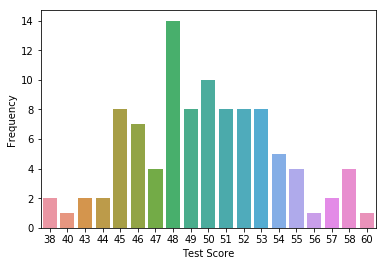

In [26]:
dataframe = test_score_distribution.DataFrame()

%matplotlib inline
import seaborn

plot = seaborn.barplot(x='Test Score',y='Frequency', data=dataframe)